# *SIAMESE NETWORKS* for Ad Detection

In [1]:
file_path = r"./"

In [2]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from keras.preprocessing import image

def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
#//TODO: figure out how to initialize layer biases in keras.
def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

input_shape = (105, 105, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)
#build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(Flatten())
convnet.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))
#encode each of the two inputs into a vector with the convnet
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)
#merge two encoded inputs with the l1 distance between them
L1_distance = lambda x: K.abs(x[0]-x[1])
both = merge([encoded_l,encoded_r], mode = L1_distance, output_shape=lambda x: x[0])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(both)
siamese_net = Model(input=[left_input,right_input],output=prediction)
#optimizer = SGD(0.0004,momentum=0.6,nesterov=True,decay=0.0003)

optimizer = Adam(0.00006)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)

siamese_net.count_params()


Using TensorFlow backend.
/home/heshan/anaconda3/envs/keras_latest/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/heshan/anaconda3/envs/keras_latest/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/heshan/anaconda3/envs/keras_latest/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


38951745

In [11]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self,path, genre):
        self.data = {}
        self.categories = {}
        path = f"{path}/{genre}"
        if genre == "_omniglot_data":
            with open(os.path.join(path,"train.pickle"),"rb") as f:
                (X,c) = pickle.load(f)
                self.data["train"] = X
                self.categories["train"] = c
            with open(os.path.join(path,"val.pickle"),"rb") as f:
                (X,c) = pickle.load(f)
                self.data["val"] = X
                self.categories["val"] = c
        else:
            with open(os.path.join(path,"train.pickle"),"rb") as f:
                X = pickle.load(f)
                self.data["train"] = X
            with open(os.path.join(path,"val.pickle"),"rb") as f:
                X = pickle.load(f)
                self.data["val"] = X
            
        self.n_classes,self.n_examples,self.w,self.h = self.data["train"].shape
        self.n_val,self.n_ex_val,_,_ = self.data['val'].shape

    def get_batch(self,n,s="train"):
        """Create batch of n pairs, half same class, half different class"""
        X=self.data[s]
        categories = rng.choice(self.n_classes,size=(n,),replace=False)
        pairs=[np.zeros((n, self.h, self.w,1)) for i in range(2)]
        targets=np.zeros((n,))
        targets[n//2:] = 1
        for i in range(n):
            category = categories[i]
            idx_1 = rng.randint(0,self.n_examples)
            pairs[0][i,:,:,:] = X[category,idx_1].reshape(self.w,self.h,1)
            idx_2 = rng.randint(0,self.n_examples)
            #pick images of same class for 1st half, different for 2nd
            category_2 = category if i >= n//2 else (category + rng.randint(1,self.n_classes)) % self.n_classes
            pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(self.w,self.h,1)
        return pairs, targets

    def make_oneshot_task(self,N,s="val"):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        X=self.data[s]
        n_classes, n_examples = X.shape[0],X.shape[1]
       
        categories = rng.choice(range(n_classes),size=(N,),replace=False)
    
        indices = rng.randint(0,self.n_examples,size=(N,))
        true_category = categories[0]
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N,self.w,self.h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N,self.w,self.h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets

    def jam_detector(self,N=1):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        f = open("./jam_bottles.pickle", 'rb')
        X=pickle.load(f)
        n_classes, n_examples = X.shape[0],X.shape[1]
        
#         categories = np.array([0, 1])
        
#         indices = rng.randint(0,n_examples,size=(N,))
        category = rng.randint(0,n_classes)
        ex1 = rng.randint(0,n_examples)
#         _, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[category,ex1,:,:]]*N).reshape(N,self.w,self.h,1)
        control = X[0,0,:,:]
#         support_set[0,:,:] = X[true_category,ex2]
        control = control.reshape(N,self.w,self.h,1)
#         targets = np.zeros((N,))
#         targets[0] = 1
#         targets, test_image, control = shuffle(targets, test_image, control)
        pairs = [test_image,control]

        return pairs, category #, targets
    
    def make_සිංහල_oneshot_task(self,N,s="val",language=None):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        X=self.data[s]
        fs = open("./සිංහල.pickle", "rb")
        Xs = pickle.load(fs)
        s_classes, s_examples = Xs.shape[0], Xs.shape[1]
        n_classes, n_examples = X.shape[0],X.shape[1]
        
        categories = rng.choice(range(n_classes),size=(N,),replace=False)
        
        indices = rng.randint(0,self.n_examples,size=(N,))
        
        අකුර = rng.choice(s_classes,replace=False,size=(1,))
        
        true_category = අකුර[0]
        ex1, ex2 = rng.choice(s_examples,replace=False,size=(2,))
        test_image = np.asarray([Xs[true_category,ex1,:,:]]*N).reshape(N,self.w,self.h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = Xs[true_category,ex2]
        support_set = support_set.reshape(N,self.w,self.h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets 

    def make_adframe_sizing_oneshot_task(self,N):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        f = open("./ad_frames_new.pickle", 'rb')
        X=pickle.load(f)
        n_classes, n_examples = X.shape[0],X.shape[1]
        
        categories = rng.choice(range(n_classes),size=(N,),replace=False)
        
        indices = rng.randint(0,self.n_examples,size=(N,))
        true_category = categories[0]
        ex1 = 0
        _, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N,self.w,self.h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N,self.w,self.h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    
    def test_oneshot(self,model,N,k,s="val",verbose=0, sinhala = False, ad_frame = False):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} unique {} way one-shot learning tasks ...".format(k,N))
        if sinhala:
            for i in range(k):
                inputs, targets = self.make_සිංහල_oneshot_task(N,s)
                probs = model.predict(inputs)
                if np.argmax(probs) == np.argmax(targets):
                    n_correct+=1
            percent_correct = (100.0*n_correct / k)
        elif ad_frame:
            for i in range(k):
                inputs, targets = self.make_adframe_oneshot_task(N)
                probs = model.predict(inputs)
                if np.argmax(probs) == np.argmax(targets):
                    n_correct+=1
            percent_correct = (100.0*n_correct / k)
        else:
            for i in range(k):
                inputs, targets = self.make_oneshot_task(N,s)
                probs = model.predict(inputs)
                if np.argmax(probs) == np.argmax(targets):
                    n_correct+=1
            percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct

In [12]:
loader = Siamese_Loader(file_path, "_omniglot_data")

## Visualizing the inputs and results

In [6]:

def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc,h,w,_ = X.shape
    X = X.reshape(nc,h,w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task(pairs):
    """Takes a one-shot task given to a siamese net and  """
    fig,(ax1,ax2) = plt.subplots(1,2)
    ax1.matshow(pairs[0][0].reshape(105,105),cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

def plot_oneshot_result(pairs, result):
    """Takes a one-shot results given by siamese net and provide visual evidence"""
    fig,(ax1,ax2, ax3) = plt.subplots(1,3)
    ax1.matshow(pairs[0][0].reshape(105,105),cmap='gray')
    ax2.matshow(pairs[1][0].reshape(105,105),cmap='gray')
#     img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax2.get_xaxis().set_visible(False)
#     ax2.matshow(img, cmap='gray')
    ax3.matshow(result, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()
#example of a one-shot learning task
# pairs, targets = loader.make_oneshot_task(20,"val") #,"Hebrew")
# plot_oneshot_task(pairs)
# # print(targets)
# # print(np.array(pairs))
# print(targets.reshape(4,5))


In [7]:
#Training loop
evaluate_every = 2000
loss_every=1000
batch_size = 32
N_way = 500
n_val = 250
best = 0
for i in range(1,2000000):
    (inputs,targets)=loader.get_batch(batch_size)
    loss=siamese_net.train_on_batch(inputs,targets)
    if i % evaluate_every == 0:
        val_acc = loader.test_oneshot(siamese_net,N_way,n_val,verbose=True)
        if val_acc >= best:
            print("saving")
            siamese_net.save(file_path+'/weights')
            best=val_acc

    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i,loss))

      


iteration 1000, training loss: 0.98,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 11.6% 500 way one-shot learning accuracy
saving
iteration 2000, training loss: 0.69,
iteration 3000, training loss: 0.38,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 25.2% 500 way one-shot learning accuracy
saving
iteration 4000, training loss: 0.50,
iteration 5000, training loss: 0.28,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 27.6% 500 way one-shot learning accuracy
saving
iteration 6000, training loss: 0.39,
iteration 7000, training loss: 0.27,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 26.0% 500 way one-shot learning accuracy
iteration 8000, training loss: 0.29,
iteration 9000, training loss: 0.17,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 30.0% 500 way one-shot learning accuracy
saving
iteration

Got an average of 38.0% 500 way one-shot learning accuracy
iteration 82000, training loss: 0.09,
iteration 83000, training loss: 0.33,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 43.6% 500 way one-shot learning accuracy
iteration 84000, training loss: 0.09,
iteration 85000, training loss: 0.15,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 44.4% 500 way one-shot learning accuracy
iteration 86000, training loss: 0.16,
iteration 87000, training loss: 0.18,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 38.4% 500 way one-shot learning accuracy
iteration 88000, training loss: 0.10,
iteration 89000, training loss: 0.09,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 45.6% 500 way one-shot learning accuracy
iteration 90000, training loss: 0.20,
iteration 91000, training loss: 0.10,
Evaluating model on 250 unique 500 way one-shot learning 

iteration 163000, training loss: 0.10,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 41.2% 500 way one-shot learning accuracy
iteration 164000, training loss: 0.12,
iteration 165000, training loss: 0.07,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 44.8% 500 way one-shot learning accuracy
iteration 166000, training loss: 0.09,
iteration 167000, training loss: 0.09,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 50.4% 500 way one-shot learning accuracy
saving
iteration 168000, training loss: 0.10,
iteration 169000, training loss: 0.13,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 40.4% 500 way one-shot learning accuracy
iteration 170000, training loss: 0.09,
iteration 171000, training loss: 0.08,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 42.4% 500 way one-shot learning accuracy
iteration 17

Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 42.8% 500 way one-shot learning accuracy
iteration 244000, training loss: 0.07,
iteration 245000, training loss: 0.09,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 43.2% 500 way one-shot learning accuracy
iteration 246000, training loss: 0.07,
iteration 247000, training loss: 0.07,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 47.2% 500 way one-shot learning accuracy
iteration 248000, training loss: 0.07,
iteration 249000, training loss: 0.08,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 42.0% 500 way one-shot learning accuracy
iteration 250000, training loss: 0.08,
iteration 251000, training loss: 0.07,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 40.8% 500 way one-shot learning accuracy
iteration 252000, training loss: 0.08,
iteration 253000, t

Got an average of 47.6% 500 way one-shot learning accuracy
iteration 324000, training loss: 0.07,
iteration 325000, training loss: 0.07,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 45.2% 500 way one-shot learning accuracy
iteration 326000, training loss: 0.11,
iteration 327000, training loss: 0.08,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 43.6% 500 way one-shot learning accuracy
iteration 328000, training loss: 0.07,
iteration 329000, training loss: 0.24,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 53.6% 500 way one-shot learning accuracy
saving
iteration 330000, training loss: 0.07,
iteration 331000, training loss: 0.07,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 45.2% 500 way one-shot learning accuracy
iteration 332000, training loss: 0.07,
iteration 333000, training loss: 0.07,
Evaluating model on 250 unique 500 way o

iteration 405000, training loss: 0.07,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 46.0% 500 way one-shot learning accuracy
iteration 406000, training loss: 0.07,
iteration 407000, training loss: 0.08,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 48.0% 500 way one-shot learning accuracy
iteration 408000, training loss: 0.07,
iteration 409000, training loss: 0.06,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 48.8% 500 way one-shot learning accuracy
iteration 410000, training loss: 0.09,
iteration 411000, training loss: 0.10,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 46.4% 500 way one-shot learning accuracy
iteration 412000, training loss: 0.06,
iteration 413000, training loss: 0.07,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 47.6% 500 way one-shot learning accuracy
iteration 414000, t

Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 48.0% 500 way one-shot learning accuracy
iteration 486000, training loss: 0.08,
iteration 487000, training loss: 0.06,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 54.4% 500 way one-shot learning accuracy
saving
iteration 488000, training loss: 0.06,
iteration 489000, training loss: 0.09,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 46.8% 500 way one-shot learning accuracy
iteration 490000, training loss: 0.06,
iteration 491000, training loss: 0.07,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 47.6% 500 way one-shot learning accuracy
iteration 492000, training loss: 0.06,
iteration 493000, training loss: 0.06,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 49.6% 500 way one-shot learning accuracy
iteration 494000, training loss: 0.06,
iteration 49

Got an average of 51.2% 500 way one-shot learning accuracy
iteration 566000, training loss: 0.06,
iteration 567000, training loss: 0.06,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 44.4% 500 way one-shot learning accuracy
iteration 568000, training loss: 0.06,
iteration 569000, training loss: 0.06,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 46.0% 500 way one-shot learning accuracy
iteration 570000, training loss: 0.06,
iteration 571000, training loss: 0.06,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 43.2% 500 way one-shot learning accuracy
iteration 572000, training loss: 0.06,
iteration 573000, training loss: 0.06,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 50.0% 500 way one-shot learning accuracy
iteration 574000, training loss: 0.06,
iteration 575000, training loss: 0.06,
Evaluating model on 250 unique 500 way one-shot

iteration 647000, training loss: 0.07,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 51.2% 500 way one-shot learning accuracy
iteration 648000, training loss: 0.24,
iteration 649000, training loss: 0.05,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 50.8% 500 way one-shot learning accuracy
iteration 650000, training loss: 0.06,
iteration 651000, training loss: 0.08,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 44.4% 500 way one-shot learning accuracy
iteration 652000, training loss: 0.05,
iteration 653000, training loss: 0.05,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 50.4% 500 way one-shot learning accuracy
iteration 654000, training loss: 0.06,
iteration 655000, training loss: 0.06,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 52.0% 500 way one-shot learning accuracy
iteration 656000, t

Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 47.6% 500 way one-shot learning accuracy
iteration 728000, training loss: 0.05,
iteration 729000, training loss: 0.06,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 50.4% 500 way one-shot learning accuracy
iteration 730000, training loss: 0.06,
iteration 731000, training loss: 0.13,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 54.0% 500 way one-shot learning accuracy
iteration 732000, training loss: 0.05,
iteration 733000, training loss: 0.06,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 50.0% 500 way one-shot learning accuracy
iteration 734000, training loss: 0.05,
iteration 735000, training loss: 0.14,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 50.8% 500 way one-shot learning accuracy
iteration 736000, training loss: 0.05,
iteration 737000, t

Got an average of 44.8% 500 way one-shot learning accuracy
iteration 808000, training loss: 0.20,
iteration 809000, training loss: 0.06,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 47.2% 500 way one-shot learning accuracy
iteration 810000, training loss: 0.05,
iteration 811000, training loss: 0.06,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 56.0% 500 way one-shot learning accuracy
iteration 812000, training loss: 0.04,
iteration 813000, training loss: 0.05,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 49.6% 500 way one-shot learning accuracy
iteration 814000, training loss: 0.05,
iteration 815000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 46.0% 500 way one-shot learning accuracy
iteration 816000, training loss: 0.05,
iteration 817000, training loss: 0.06,
Evaluating model on 250 unique 500 way one-shot

iteration 889000, training loss: 0.05,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 50.0% 500 way one-shot learning accuracy
iteration 890000, training loss: 0.06,
iteration 891000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 47.2% 500 way one-shot learning accuracy
iteration 892000, training loss: 0.07,
iteration 893000, training loss: 0.05,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 42.4% 500 way one-shot learning accuracy
iteration 894000, training loss: 0.04,
iteration 895000, training loss: 0.06,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 50.0% 500 way one-shot learning accuracy
iteration 896000, training loss: 0.05,
iteration 897000, training loss: 0.05,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 49.2% 500 way one-shot learning accuracy
iteration 898000, t

Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 46.4% 500 way one-shot learning accuracy
iteration 970000, training loss: 0.04,
iteration 971000, training loss: 0.05,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 50.8% 500 way one-shot learning accuracy
iteration 972000, training loss: 0.04,
iteration 973000, training loss: 0.05,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 53.6% 500 way one-shot learning accuracy
iteration 974000, training loss: 0.05,
iteration 975000, training loss: 0.07,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 52.0% 500 way one-shot learning accuracy
iteration 976000, training loss: 0.06,
iteration 977000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 43.6% 500 way one-shot learning accuracy
iteration 978000, training loss: 0.05,
iteration 979000, t

Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 49.6% 500 way one-shot learning accuracy
iteration 1050000, training loss: 0.05,
iteration 1051000, training loss: 0.07,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 43.6% 500 way one-shot learning accuracy
iteration 1052000, training loss: 0.05,
iteration 1053000, training loss: 0.09,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 42.0% 500 way one-shot learning accuracy
iteration 1054000, training loss: 0.11,
iteration 1055000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 47.6% 500 way one-shot learning accuracy
iteration 1056000, training loss: 0.04,
iteration 1057000, training loss: 0.08,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 54.0% 500 way one-shot learning accuracy
iteration 1058000, training loss: 0.14,
iteration 

iteration 1129000, training loss: 0.05,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 51.2% 500 way one-shot learning accuracy
iteration 1130000, training loss: 0.13,
iteration 1131000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 47.2% 500 way one-shot learning accuracy
iteration 1132000, training loss: 0.14,
iteration 1133000, training loss: 0.05,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 47.6% 500 way one-shot learning accuracy
iteration 1134000, training loss: 0.06,
iteration 1135000, training loss: 0.06,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 48.4% 500 way one-shot learning accuracy
iteration 1136000, training loss: 0.04,
iteration 1137000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 48.4% 500 way one-shot learning accuracy
iteration 

iteration 1209000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 56.4% 500 way one-shot learning accuracy
iteration 1210000, training loss: 0.04,
iteration 1211000, training loss: 0.23,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 51.6% 500 way one-shot learning accuracy
iteration 1212000, training loss: 0.05,
iteration 1213000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 48.8% 500 way one-shot learning accuracy
iteration 1214000, training loss: 0.04,
iteration 1215000, training loss: 0.06,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 53.2% 500 way one-shot learning accuracy
iteration 1216000, training loss: 0.06,
iteration 1217000, training loss: 0.06,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 50.4% 500 way one-shot learning accuracy
iteration 

iteration 1289000, training loss: 0.05,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 53.2% 500 way one-shot learning accuracy
iteration 1290000, training loss: 0.04,
iteration 1291000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 48.0% 500 way one-shot learning accuracy
iteration 1292000, training loss: 0.07,
iteration 1293000, training loss: 0.05,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 48.0% 500 way one-shot learning accuracy
iteration 1294000, training loss: 0.04,
iteration 1295000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 49.6% 500 way one-shot learning accuracy
iteration 1296000, training loss: 0.06,
iteration 1297000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 48.4% 500 way one-shot learning accuracy
iteration 

iteration 1369000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 56.0% 500 way one-shot learning accuracy
iteration 1370000, training loss: 0.05,
iteration 1371000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 43.6% 500 way one-shot learning accuracy
iteration 1372000, training loss: 0.06,
iteration 1373000, training loss: 0.09,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 53.2% 500 way one-shot learning accuracy
iteration 1374000, training loss: 0.12,
iteration 1375000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 48.8% 500 way one-shot learning accuracy
iteration 1376000, training loss: 0.04,
iteration 1377000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 50.0% 500 way one-shot learning accuracy
iteration 

iteration 1449000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 51.2% 500 way one-shot learning accuracy
iteration 1450000, training loss: 0.04,
iteration 1451000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 49.2% 500 way one-shot learning accuracy
iteration 1452000, training loss: 0.04,
iteration 1453000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 52.8% 500 way one-shot learning accuracy
iteration 1454000, training loss: 0.08,
iteration 1455000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 53.2% 500 way one-shot learning accuracy
iteration 1456000, training loss: 0.04,
iteration 1457000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 52.8% 500 way one-shot learning accuracy
iteration 

iteration 1529000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 54.4% 500 way one-shot learning accuracy
iteration 1530000, training loss: 0.16,
iteration 1531000, training loss: 0.27,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 45.6% 500 way one-shot learning accuracy
iteration 1532000, training loss: 0.08,
iteration 1533000, training loss: 0.05,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 48.0% 500 way one-shot learning accuracy
iteration 1534000, training loss: 0.07,
iteration 1535000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 54.0% 500 way one-shot learning accuracy
iteration 1536000, training loss: 0.03,
iteration 1537000, training loss: 0.03,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 50.0% 500 way one-shot learning accuracy
iteration 

iteration 1609000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 48.8% 500 way one-shot learning accuracy
iteration 1610000, training loss: 0.07,
iteration 1611000, training loss: 0.07,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 50.4% 500 way one-shot learning accuracy
iteration 1612000, training loss: 0.13,
iteration 1613000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 48.8% 500 way one-shot learning accuracy
iteration 1614000, training loss: 0.03,
iteration 1615000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 53.2% 500 way one-shot learning accuracy
iteration 1616000, training loss: 0.04,
iteration 1617000, training loss: 0.08,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 48.8% 500 way one-shot learning accuracy
iteration 

iteration 1689000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 52.4% 500 way one-shot learning accuracy
iteration 1690000, training loss: 0.05,
iteration 1691000, training loss: 0.07,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 60.8% 500 way one-shot learning accuracy
saving
iteration 1692000, training loss: 0.17,
iteration 1693000, training loss: 0.06,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 57.2% 500 way one-shot learning accuracy
iteration 1694000, training loss: 0.04,
iteration 1695000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 43.2% 500 way one-shot learning accuracy
iteration 1696000, training loss: 0.06,
iteration 1697000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 50.0% 500 way one-shot learning accuracy
ite

iteration 1769000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 45.6% 500 way one-shot learning accuracy
iteration 1770000, training loss: 0.04,
iteration 1771000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 50.4% 500 way one-shot learning accuracy
iteration 1772000, training loss: 0.03,
iteration 1773000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 51.6% 500 way one-shot learning accuracy
iteration 1774000, training loss: 0.06,
iteration 1775000, training loss: 0.06,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 48.4% 500 way one-shot learning accuracy
iteration 1776000, training loss: 0.04,
iteration 1777000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 52.8% 500 way one-shot learning accuracy
iteration 

iteration 1849000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 56.0% 500 way one-shot learning accuracy
iteration 1850000, training loss: 0.03,
iteration 1851000, training loss: 0.03,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 50.0% 500 way one-shot learning accuracy
iteration 1852000, training loss: 0.04,
iteration 1853000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 51.2% 500 way one-shot learning accuracy
iteration 1854000, training loss: 0.03,
iteration 1855000, training loss: 0.03,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 49.2% 500 way one-shot learning accuracy
iteration 1856000, training loss: 0.03,
iteration 1857000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 52.4% 500 way one-shot learning accuracy
iteration 

iteration 1929000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 52.0% 500 way one-shot learning accuracy
iteration 1930000, training loss: 0.03,
iteration 1931000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 45.2% 500 way one-shot learning accuracy
iteration 1932000, training loss: 0.03,
iteration 1933000, training loss: 0.05,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 52.8% 500 way one-shot learning accuracy
iteration 1934000, training loss: 0.07,
iteration 1935000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 54.0% 500 way one-shot learning accuracy
iteration 1936000, training loss: 0.05,
iteration 1937000, training loss: 0.04,
Evaluating model on 250 unique 500 way one-shot learning tasks ...
Got an average of 51.2% 500 way one-shot learning accuracy
iteration 

In [7]:
siamese_net.load_weights(f"{file_path}/weights_500_2000000_60")

In [ ]:
siamese_net.summary()

In [17]:
l = dict((layer.name,layer) for layer in siamese_net.layers)
l

{'dense_2': <keras.layers.core.Dense at 0x7fafe3e61e10>,
 'input_1': <keras.engine.topology.InputLayer at 0x7fb058345cf8>,
 'input_2': <keras.engine.topology.InputLayer at 0x7fb058345d30>,
 'merge_1': <keras.legacy.layers.Merge at 0x7fafe3e87438>,
 'sequential_1': <keras.models.Sequential at 0x7fb05dfac630>}

## Testing the model with oneshot tasks

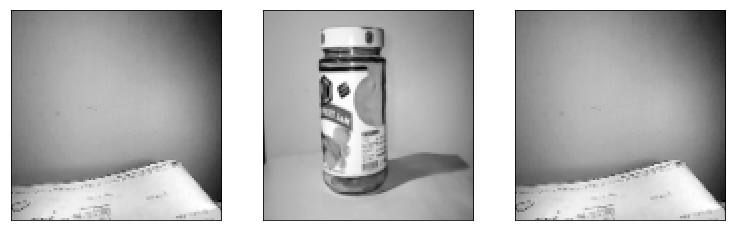

0.000493722 Not Bottle


In [21]:
plt.style.use('seaborn-poster')
pairs, cat = loader.jam_detector()

# inputs = pairs
p=np.array(siamese_net.predict(pairs))

l = np.where(p==np.max(p))
if p[0][0]>0.1:
    result = pairs[1][0,:,:,:].reshape(105, 105)
    out = 'Bottle'
else:
    result = pairs[0][0,:,:,:].reshape(105, 105)
    out = 'Not Bottle'
    

plot_oneshot_result(pairs, result)
print(p[0][0], out)

In [29]:
def test_accuracy(epochs=100):
    acc = 0
    for _ in range(epochs):
        pairs, cat = loader.jam_detector()
        p = siamese_net.predict(pairs)
        
        if (p[0][0]>0.1 and cat == 0) or (p[0][0]<=0.1 and cat == 1):
            acc += 1
    
    return f"{acc/epochs*100}%"

epochs = 10000
print(f"Accuracy for {epochs} epochs : {test_accuracy(epochs)}")   
    

Accuracy for 10000 epochs : 84.3%


In [106]:
print(p[0][0])
np.array(pairs).shape

0.0277789


(2, 1, 105, 105, 1)

## Assembling data for feeding 

In [7]:
def assemble_සිංහල_dataset():
    import os
    fpath = "./Sinhala"
    f = open("./සිංහල.pickle", "wb")
    Xs = []
    for i in range(1, 5):
        l = os.listdir(f"{fpath}/{i}")
        අකුර = []
        for j in l[:20]:
            im = image.img_to_array(image.load_img(f"{fpath}/{i}/{j}", target_size=(105, 105)))
            im = im[:,:,0]
#             print(i, j, im.shape)
            අකුර.append(im)
        Xs.append(අකුර)
    pickle.dump(np.array(Xs), f)

def assemble_dataset(fpath, num_classes, num_examples, pickle_file):
    import os
    f = open(pickle_file, "wb")
    Xd = []
    m = os.listdir(f"{fpath}")
    for i in m:
        l = os.listdir(f"{fpath}/{i}")
        x = []
        if len(l)>= num_examples:
            for j in l[:num_examples]:
                im = image.img_to_array(image.load_img(f"{fpath}/{i}/{j}", target_size=(105, 105)))
                im = (im[:,:,0]+im[:,:,1]+im[:,:,2])/3
                print(i, j, im.shape)
                x.append(im)
            Xd.append(x)
    pickle.dump(np.array(Xd), f)
    print(np.array(Xd).shape)

In [8]:
assemble_dataset("./Image_Data/Jam_Bottle", 2, 130, "./jam_bottles.pickle")
# assemble_dataset("./Image_Data/COCO_val", 1000, 20, "./_coco_data/val.pickle")

positives 1000.bmp (105, 105)
positives 1001.bmp (105, 105)
positives 1002.bmp (105, 105)
positives 1003.bmp (105, 105)
positives 1004.bmp (105, 105)
positives 1005.bmp (105, 105)
positives 1006.bmp (105, 105)
positives 1007.bmp (105, 105)
positives 1008.bmp (105, 105)
positives 1009.bmp (105, 105)
positives 1010.bmp (105, 105)
positives 1011.bmp (105, 105)
positives 1012.bmp (105, 105)
positives 1013.bmp (105, 105)
positives 1014.bmp (105, 105)
positives 1015.bmp (105, 105)
positives 1016.bmp (105, 105)
positives 1017.bmp (105, 105)
positives 1018.bmp (105, 105)
positives 1019.bmp (105, 105)
positives 1020.bmp (105, 105)
positives 1021.bmp (105, 105)
positives 1022.bmp (105, 105)
positives 1023.bmp (105, 105)
positives 1024.bmp (105, 105)
positives 1025.bmp (105, 105)
positives 1026.bmp (105, 105)
positives 1027.bmp (105, 105)
positives 1028.bmp (105, 105)
positives 1029.bmp (105, 105)
positives 1030.bmp (105, 105)
positives 1031.bmp (105, 105)
positives 1032.bmp (105, 105)
positives 

## Loading an image

In [57]:
f = open("./සිංහල.pickle", "rb")
Xs = pickle.load(f)
print(Xs.shape)

(4, 20, 105, 105)


In [144]:
f = open("./ad_frames_new.pickle", "rb")
Xy = pickle.load(f)
print(Xy.shape)

(28, 20, 105, 105)


In [34]:
f = open("./_coco_data/train.pickle", "rb")
Xt = pickle.load(f)
f.close()
f = open("./_coco_data/val.pickle", "rb")
Xv = pickle.load(f)
f.close()

## Creating Classes Using Augmentation

In [5]:
in_folder = './Image_Data/COCO'
dat_type = 'val'

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

im_list = os.listdir(in_folder)

for i, im in enumerate(im_list[2000:3000]):
    os.mkdir(str(i+1))    
    img = load_img(f'{in_folder}/{im}')  # this is a PIL image
    x = img_to_array(img)  # this is a Numpy array with shape (150, 150, 3)
#     x = sum([x[:,:,i] for i in range(3)])/3
    x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 150, 150, 3)

    # the .flow() command below generates batches of randomly transformed images
    # and saves the results to the `preview/` directory
    j = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir=f'./{i+1}', save_prefix=f'{dat_type}', save_format='jpeg'):
        j += 1
        if j > 25:
            break  # otherwise the generator would loop indefinitely